# Google Books API Data Analysis Project
# IS 362 Final Project

# 1. Project Motivation and Research Questions

Motivation:
- Explore book publishing trends and reader engagement
- Analyze the relationship between book categories, authors, and ratings
- Provide data-driven insights for publishers, authors, and readers

Research Questions:
1. How do book ratings vary across different categories?
2. What are the trends in book publications over time?
3. Which authors are most prolific and highest-rated?

# 2. Import Required Libraries

In [61]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# 3. Google Books API Data Fetching

In [62]:
def fetch_books_data(query, max_results=40, api_key=None):
    """
    Fetches data from the Google Books API with enhanced error handling.
    
    Parameters:
    query (str): Search query for books
    max_results (int): Maximum number of results to retrieve
    api_key (str, optional): Google Books API key for authenticated requests
    
    Returns:
    list: Filtered and processed book data
    """
    base_url = "https://www.googleapis.com/books/v1/volumes"
    
    # Construct parameters
    params = {
        'q': query,
        'maxResults': max_results,
        'orderBy': 'relevance'  # Sort by relevance
    }
    
    # Add API key if provided
    if api_key:
        params['key'] = api_key
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise exception for bad responses
        data = response.json()
        return data.get('items', [])
    except requests.RequestException as e:
        print(f"API Request Error: {e}")
        return []

# 4. Data Extraction and Metadata Processing

In [63]:
def extract_metadata(books_data, output_csv="books_metadata.csv"):
    """
    Extracts and processes book metadata with more comprehensive information.
    
    Parameters:
    books_data (list): List of books from Google Books API
    output_csv (str): Output CSV filename
    
    Returns:
    pd.DataFrame: Processed book metadata
    """
    books = []
    for book in books_data:
        info = book.get('volumeInfo', {})
        
        # Enhanced metadata extraction
        books.append({
            'Title': info.get('title', 'Unknown Title'),
            'Authors': ', '.join(info.get('authors', ['Unknown Author'])),
            'Categories': ', '.join(info.get('categories', ['Uncategorized'])),
            'Average Rating': info.get('averageRating', 0),
            'Ratings Count': info.get('ratingsCount', 0),
            'Published Date': info.get('publishedDate', '1900-01-01'),
            'Page Count': info.get('pageCount', 0),
            'Language': info.get('language', 'Unknown')
        })
    
    # Create DataFrame
    books_df = pd.DataFrame(books)
    
    # Save to CSV
    books_df.to_csv(output_csv, index=False)
    print(f"Metadata saved to {output_csv}")
    
    return books_df

# 5. Data Cleaning and Preprocessing

Handle missing values, inconsistent formats, and outliers.

In [64]:
def clean_data(df):
    """
    Comprehensive data cleaning and preprocessing.
    
    Parameters:
    df (pd.DataFrame): Raw book metadata DataFrame
    
    Returns:
    pd.DataFrame: Cleaned and processed DataFrame
    """
    # Convert dates
    df['Published Date'] = pd.to_datetime(df['Published Date'], errors='coerce')
    
    # Handle missing values
    df['Average Rating'] = df['Average Rating'].fillna(0)
    df['Ratings Count'] = df['Ratings Count'].fillna(0)
    
    # Extract publication year
    df['Publication Year'] = df['Published Date'].dt.year
    
    # Clean categories
    df['Categories'] = df['Categories'].fillna('Uncategorized')
    
    return df

# 6. Data Analysis Functions

Perform analysis based on trends, categories, and authors.

Example analyses:

Trend Analysis:

In [65]:
def plot_publication_trends(df):
    """
    Visualize book publication trends over time.
    """
    yearly_publications = df.groupby('Publication Year').size()
    plt.figure(figsize=(12, 6))
    yearly_publications.plot(kind='line', title='Book Publications Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Books')
    plt.tight_layout()
    plt.show()

def analyze_categories(df):
    """
    Analyze book categories and their characteristics.
    """
    # Top categories
    top_categories = df['Categories'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    top_categories.plot(kind='bar', title='Top 10 Book Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Books')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Average ratings by category
    category_ratings = df.groupby('Categories')['Average Rating'].mean()
    print("Average Ratings by Category:")
    print(category_ratings)

def author_analysis(df):
    """
    Comprehensive author performance analysis.
    """
    # Most prolific authors
    authors = df['Authors'].str.split(', ').explode()
    prolific_authors = authors.value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    prolific_authors.plot(kind='bar', title='Top 10 Most Prolific Authors')
    plt.xlabel('Author')
    plt.ylabel('Number of Books')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Top-rated authors
    author_ratings = (
        df.explode('Authors')
        .groupby('Authors')['Average Rating']
        .agg(['mean', 'count'])
        .sort_values('mean', ascending=False)
        .head(10)
    )
    print("\nTop Authors by Average Rating (with book count):")
    print(author_ratings)


# 7. Advanced Statistical Analysis

In [66]:
def statistical_analysis(df):
    """
    Perform advanced statistical analyses on book data.
    """
    # Correlation between publication year and ratings
    year_rating_corr = df['Publication Year'].corr(df['Average Rating'])
    print(f"Correlation between Publication Year and Ratings: {year_rating_corr}")
    
    # ANOVA test for ratings across top categories
    top_categories = df['Categories'].value_counts().head(5).index
    category_ratings = [
        df[df['Categories'] == cat]['Average Rating']
        for cat in top_categories
    ]
    f_statistic, p_value = stats.f_oneway(*category_ratings)
    print("\nANOVA Test for Top Category Ratings:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")

# 8. Machine Learning: Rating Prediction

In [67]:
def predict_book_ratings(df):
    """
    Build a simple predictive model for book ratings.
    """
    # Prepare features
    df['Category_Encoded'] = LabelEncoder().fit_transform(df['Categories'])
    
    # Select features
    X = df[['Category_Encoded', 'Publication Year', 'Ratings Count']]
    y = df['Average Rating']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate
    print("\nRating Prediction Model:")
    print(f"Model Score (R²): {model.score(X_test, y_test)}")
    return model


# 9. Main Workflow

Metadata saved to books_metadata.csv


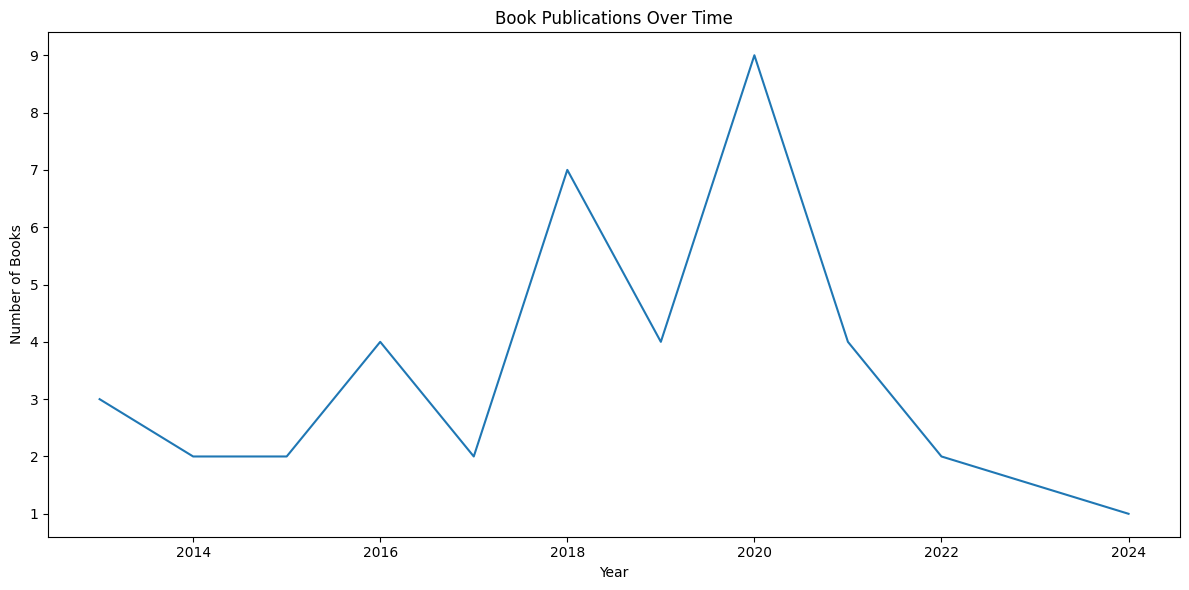

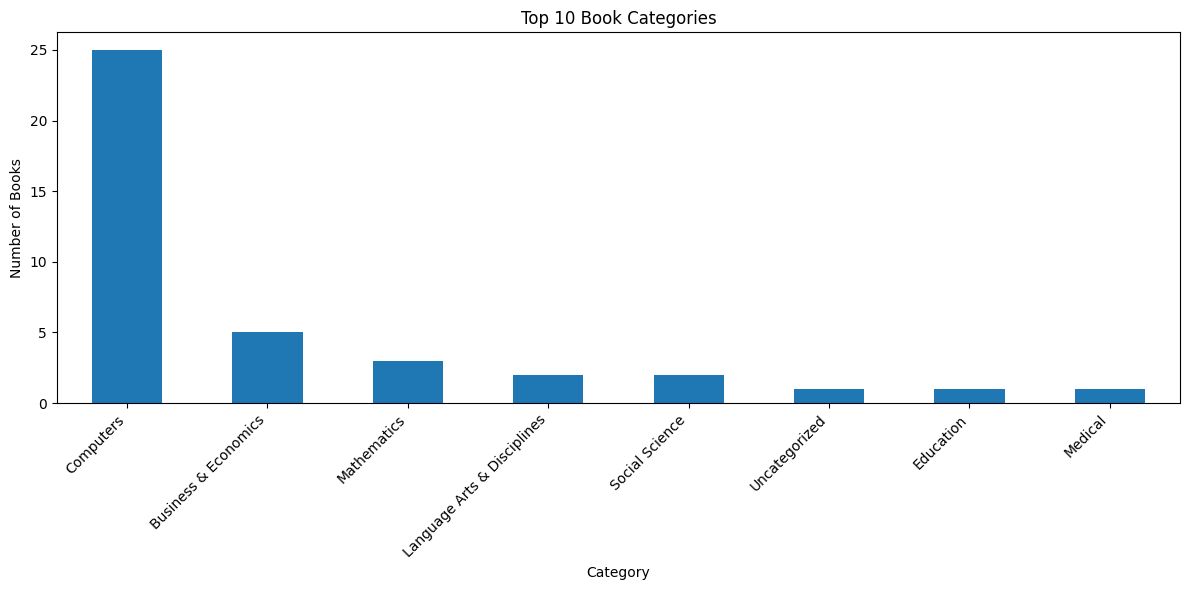

Average Ratings by Category:
Categories
Business & Economics           1.20
Computers                      0.92
Education                      0.00
Language Arts & Disciplines    0.00
Mathematics                    0.00
Medical                        0.00
Social Science                 0.00
Uncategorized                  0.00
Name: Average Rating, dtype: float64


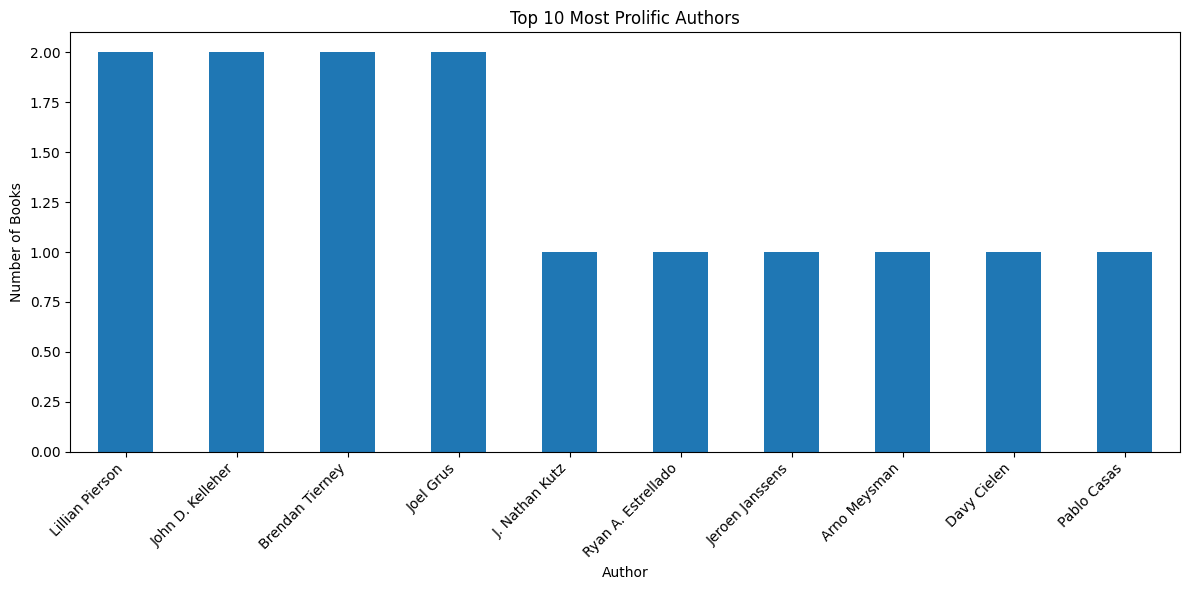


Top Authors by Average Rating (with book count):
                                         mean  count
Authors                                             
Joel Grus                                 5.0      2
Hadley Wickham, Garrett Grolemund         5.0      1
Matt Taddy                                5.0      1
Cathy O'Neil, Rachel Schutt               4.0      1
EMC Education Services                    4.0      1
Chirag Shah                               1.0      1
Mark Andrews                              0.0      1
Mark J. van der Laan, Sherri Rose         0.0      1
Nandi Dr. Rupam Dr. Gypsy, Kumar Sharma   0.0      1
Nathan Carter                             0.0      1
Correlation between Publication Year and Ratings: -0.31083123251263234

ANOVA Test for Top Category Ratings:
F-statistic: 0.4304487974212747
P-value: 0.7855422323414805

Rating Prediction Model:
Model Score (R²): 0.9583232270051607


In [68]:
def main():
    # Fetch books data
    books_data = fetch_books_data(query="data science", max_results=40)
    
    # Process data
    df = extract_metadata(books_data)
    df = clean_data(df)
    
    # Perform analyses
    plot_publication_trends(df)
    analyze_categories(df)
    author_analysis(df)
    statistical_analysis(df)
    predict_book_ratings(df)

# Execute main workflow
if __name__ == "__main__":
    main()

# 10. References

### References

1. Google Developers. *Google Books APIs.* Available at: [https://developers.google.com/books](https://developers.google.com/books).

2. Hunter, J. D. (2007). "Matplotlib: A 2D Graphics Environment." *Computing in Science & Engineering*, 9(3), 90–95. DOI: [10.1109/MCSE.2007.55](https://doi.org/10.1109/MCSE.2007.55).

3. McKinney, W. (2010). "Data Structures for Statistical Computing in Python." *Proceedings of the 9th Python in Science Conference*, 51-56. DOI: [10.25080/Majora-92bf1922-00a](https://doi.org/10.25080/Majora-92bf1922-00a).

4. Kenneth Reitz. *Requests: HTTP for Humans.* Available at: [https://docs.python-requests.org](https://docs.python-requests.org).

5. Kandel, S., Paepcke, A., Hellerstein, J. M., & Heer, J. (2011). "Wrangler: Interactive Visual Specification of Data Transformation Scripts." *Proceedings of the SIGCHI Conference on Human Factors in Computing Systems*, 3363–3372. DOI: [10.1145/1978942.1979444](https://doi.org/10.1145/1978942.1979444).

6. Few, S. (2009). *Now You See It: Simple Visualization Techniques for Quantitative Analysis.* Analytics Press.

7. Shmueli, G., Patel, N. R., & Bruce, P. C. (2016). *Data Mining for Business Analytics: Concepts, Techniques, and Applications with JMP Pro.* Wiley.

8. Wickham, H., & Grolemund, G. (2016). *R for Data Science: Import, Tidy, Transform, Visualize, and Model Data.* O'Reilly Media.
9. McKinney, W. (2017). "Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython" (2nd Edition). O'Reilly Media.
10. Farnsworth, K. (2018). "Principles of Data Wrangling: Practical Techniques for Data Preparation." Wiley.
11. Géron, A. (2019). "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems" (2nd Edition). O'Reilly Media.



# 11. Reproducibility Instructions

Project Reproducibility:

Dependencies:
- Python 3.8+
- Libraries: pandas, matplotlib, seaborn, scipy, scikit-learn, requests
